## Libraries

In [1]:
import re
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

In [2]:
df = pd.DataFrame()

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        df = pd.concat([df, pd.read_excel(path)], ignore_index=True)
        
df

,Lyrics
0,dön artık ne olur gel artık ne olur nerdesin a...
1,Ne sen mutlu oldun nede ben mutlu
2,İşte hem sen soldun hem de ben soldum
3,Bu ayrılıktan söyle ne buldun ne buldun
4,Aşkımızın sonu acılı sevda
...,...
222527,"Bir kazma al bir kürek aman aman,"
222528,Mezarımı kaz gayrı
222529,".Gündoğdu aştı böyle aman, Gönüldür coştu böyl..."
222530,"Sen orada ben burda aman aman,"


## Data Processing

In [3]:
df['Lyrics'] = df['Lyrics'].astype(str)

df['Lyric-Length'] = df['Lyrics'].apply(len)

df_filtered = df[df['Lyric-Length']<=50].reset_index(drop=True)

outlier_df = df[df['Lyric-Length']>50].reset_index(drop=True)

df.describe()

,Lyric-Length
count,222532.000000
mean,32.881469
std,34.212626
min,1.000000
25%,22.000000
50%,29.000000
75%,37.000000
max,2401.000000


In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    if len(text) <= 50:
        return text
    else:
        return None

data = df['Lyrics']
data = data.apply(preprocess_text)
data.dropna(inplace=True)

outliers = [i for i in data if len(i)>=50]
data

1               ne sen mutlu oldun nede ben mutlu
2           işte hem sen soldun hem de ben soldum
3         bu ayrılıktan söyle ne buldun ne buldun
4                      aşkımızın sonu acılı sevda
5                          gelde bitsin bu hasret
                           ...                   
222526            kâtip ol da yaz gayrı aman aman
222527           bir kazma al bir kürek aman aman
222528                         mezarımı kaz gayrı
222530              sen orada ben burda aman aman
222531                        ömrümüz geçti böyie
Name: Lyrics, Length: 205538, dtype: object

In [5]:
all_text = ' '.join(data)
vocab = sorted(set(all_text))
unique_words = set(all_text.split())

vocab = sorted(set(all_text))
len(vocab)

86

In [6]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

## Data Visualization

In [7]:
char_to_id = {char: idx for idx, char in enumerate(vocab)}
id_to_char = {idx: char for idx, char in enumerate(vocab)}

data_ids = [[char_to_id[char] for char in sentence] for sentence in data]
data_series = [pd.Series(sentence_ids) for sentence_ids in data_ids]

outliers_data_ids = [[char_to_id[char] for char in sentence] for sentence in outliers]
outliers_data_series = [pd.Series(sentence_ids) for sentence_ids in outliers_data_ids]

### KMeans Clustering

In [8]:
max_length = 100

In [9]:
padded_data = [sentence[:max_length] + [0] * (max_length - len(sentence)) for sentence in data_ids]
kmeans_data = KMeans(n_clusters=6, random_state=42).fit(padded_data)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
padded_outliers_data = [sentence[:max_length] + [0] * (max_length - len(sentence)) for sentence in outliers_data_ids]
kmeans_outliers = KMeans(n_clusters=6, random_state=42).fit(padded_outliers_data)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Dimension Reduction with PCA

In [11]:
pca_data = PCA(n_components=2)
pca_outliers = PCA(n_components=2)

In [12]:
data_pca = pca_data.fit_transform(padded_data)
data_cluster_labels = kmeans_data.labels_
data_cluster_centers = pca_data.transform(kmeans_data.cluster_centers_)

In [13]:
outliers_data_pca = pca_outliers.fit_transform(padded_outliers_data)
outliers_cluster_labels = kmeans_outliers.labels_
outliers_cluster_centers = pca_outliers.transform(kmeans_outliers.cluster_centers_)

### Visualization

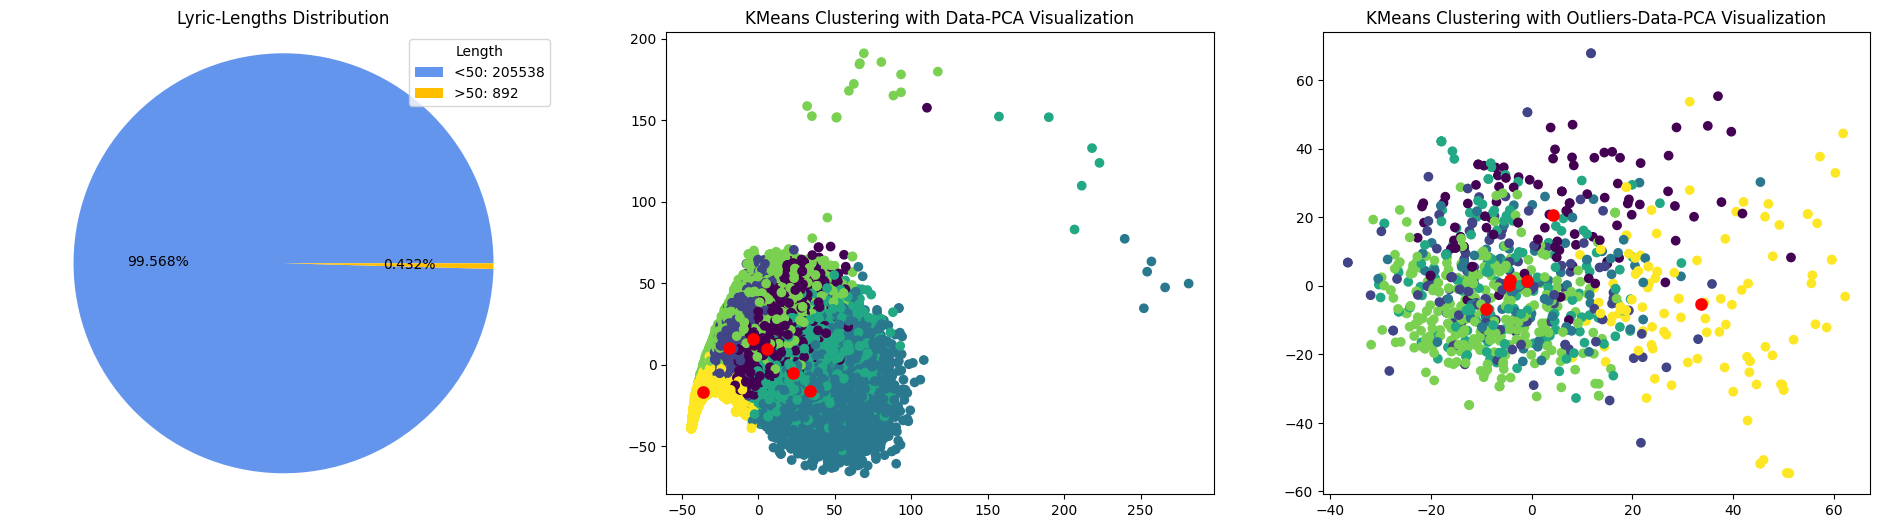

In [21]:
plt.figure(figsize=(24,6))


plt.subplot(1,3,1)

labels = ['<50', '>50']
sizes = [len(data), len(outliers)]
colors = ['#6495ED', '#FFBF00']

plt.pie(sizes, colors=colors, autopct='%1.3f%%', startangle=360)
plt.title('Lyric-Lengths Distribution')
plt.axis('equal')

legend_labels = [f'{label}: {size}' for label, size in zip(labels, sizes)]
plt.legend(legend_labels, title='Length', loc=('upper right'))


plt.subplot(1,3,2)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data_cluster_labels)
plt.scatter(data_cluster_centers[:, 0], data_cluster_centers[:, 1], marker='.', s=200, linewidths=2, color='r')

plt.title('KMeans Clustering with Data-PCA Visualization')


plt.subplot(1,3,3)

plt.scatter(outliers_data_pca[:, 0], outliers_data_pca[:, 1], c=outliers_cluster_labels)
plt.scatter(outliers_cluster_centers[:, 0], outliers_cluster_centers[:, 1], marker='.', s=200, linewidths=2, color='r')

plt.title('KMeans Clustering with Outliers-Data-PCA Visualization')


plt.show()

In [22]:
all_ids = ids_from_chars(tf.strings.unicode_split(all_text, 'UTF-8'))

In [23]:
seq_length = 50
examples_per_epoch = len(all_ids)//(seq_length+1)
sequences = tf.data.Dataset.from_tensor_slices(all_ids)
sequences = sequences.batch(seq_length+1, drop_remainder=True)

In [24]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [25]:
BATCH_SIZE = 144
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

vocab_size = len(vocab)
embedding_dim = 512
rnn_units = 100

In [26]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                    dropout=0.1)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [27]:
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [28]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(144, 50, 87) # (batch_size, sequence_length, vocab_size)


In [29]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  44544     
                                                                 
 gru (GRU)                   multiple                  184200    
                                                                 
 dense (Dense)               multiple                  8787      
                                                                 
Total params: 237,531
Trainable params: 237,531
Non-trainable params: 0
_________________________________________________________________


In [41]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [42]:
model = CustomTraining(vocab_size=len(ids_from_chars.get_vocabulary()),
                       embedding_dim=embedding_dim,
                       rnn_units=rnn_units)

In [43]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

model.fit(dataset, epochs=10)

Epoch 1/10
788/788 [==============================] - 29s 32ms/step - loss: 2.1293
Epoch 2/10
788/788 [==============================] - 24s 28ms/step - loss: 1.8009
Epoch 3/10
788/788 [==============================] - 22s 27ms/step - loss: 1.7321
Epoch 4/10
788/788 [==============================] - 25s 29ms/step - loss: 1.6986
Epoch 5/10
788/788 [==============================] - 24s 28ms/step - loss: 1.6782
Epoch 6/10
788/788 [==============================] - 23s 28ms/step - loss: 1.6643
Epoch 7/10
788/788 [==============================] - 23s 27ms/step - loss: 1.6543
Epoch 8/10
788/788 [==============================] - 24s 28ms/step - loss: 1.6466
Epoch 9/10
788/788 [==============================] - 23s 28ms/step - loss: 1.6407
Epoch 10/10
788/788 [==============================] - 22s 27ms/step - loss: 1.6357


In [44]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [45]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [50]:
start = time.time()
states = None
next_char = tf.constant(['denedim'])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
#     if next_char == " ":
#         result.append("\n")
#     else:
#         result.append(next_char)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

denedim kulbimi çağrı yoktur bir kadar her them geceli pembet yandım türküler görmedim yaydın gibi yaşamaksin sen ya bir zamanla sevdim içimden bir hatran sunah yetmem hiçrinces oyra ağaca sönün gözüşü sırmaasın severim tırmadum becanetler bırak x lavaya çıktı geçer olsa aman özlüyor beni abzi len oldun dinmiş bu nasılsa kaybolunburah biri of yıldız yüreğimi saka allah orada sakıntın sensin susarküs koysun beni su sederdiğim olmuyorum veranlardan beni bahar yaram taşınmadığıma sabah itarım duymasan kaçmanlıgöz sağsın beni hep en cele kadırmış mutluluklar l ne bu bilmem iki hakmışım acı olsa beni mekt senin bir yazdım hayaller sansım sen ben bu değil ben aradığımmı belayı bundan gelingie oludsur ağlamak vatti ktutuşun sevgisi bile kendime sümitten olgun geldi mıoy hemellere yıktı  ev bile duymuş shile the her coklu yandımaz kara çartılar yanılacağım unna bir canımı her gem affetsi reng sevinirmel geyen seslerseniz and birtasıstık ne çapulerden daha sana kimsem göm aşklalım bilinçini del